# **Final Project - Applied Machine Learning with Python FAES Course** 
## *student: Laura Palmieri*
### **Dataset: COVID-19 US; positive, death and recovered cases**
### **Project question: Prediction of recoveries and death given the available data** 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from plotly.offline import iplot, init_notebook_mode
import math
import json
import warnings
warnings.filterwarnings("ignore")

In [2]:
##Initializing and Calling data from local repos, Examples of available data for Covid-19 from online resources
import sys
ts = pd.read_csv("/Users/palmieril2/Downloads/time-series-19-covid-combined.csv")
print(ts.head(3))

         Date Country/Region Province/State   Lat  Long  Confirmed  Recovered  \
0  2020-01-22    Afghanistan            NaN  33.0  65.0        0.0        0.0   
1  2020-01-23    Afghanistan            NaN  33.0  65.0        0.0        0.0   
2  2020-01-24    Afghanistan            NaN  33.0  65.0        0.0        0.0   

   Deaths  
0     0.0  
1     0.0  
2     0.0  


In [3]:
ts.rename(columns={'Country/Region':'Country', 'Province/State':'State'}, inplace=True)
df = pd.DataFrame(ts.groupby(['Country','State'])['Confirmed','Deaths','Recovered'].max().reset_index())
print(df.head(3))

     Country                         State  Confirmed  Deaths  Recovered
0  Australia  Australian Capital Territory      106.0     3.0      103.0
1  Australia               New South Wales     3025.0    41.0     2293.0
2  Australia            Northern Territory       28.0     0.0       25.0


In [4]:
##Some Features ingeneering/transform for better visualization and data selection
covid = pd.DataFrame(ts.groupby(['Country'])['Date','Confirmed','Deaths','Recovered'].max())
import datetime as dt
covid['Date'] = pd.to_datetime(covid['Date'])
covid['Day'] = covid['Date'].dt.day
print(covid.head(3))

                  Date  Confirmed  Deaths  Recovered  Day
Country                                                  
Afghanistan 2020-04-30     2171.0    64.0      260.0   30
Albania     2020-04-30      773.0    31.0      470.0   30
Algeria     2020-04-30     4006.0   450.0     1779.0   30


2020-04-30


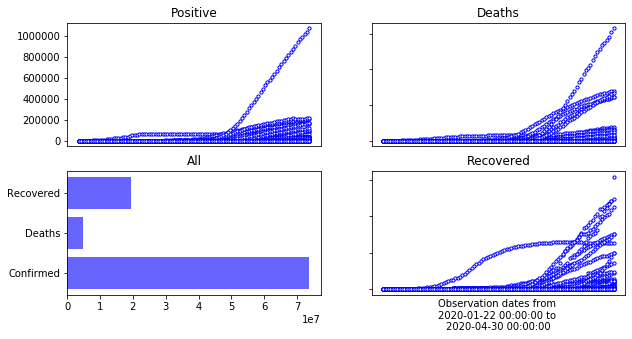

In [5]:
fig, axs = plt.subplots(2, 2, figsize=(10,5))
ms = 10; ec = 'blue'; co = 'white'
axs[0, 0].scatter(ts["Date"],ts["Confirmed"],s=ms, edgecolors=ec,color=co)
axs[0, 0].set_title('Positive')
axs[0, 0].set_xticks([])
axs[0, 1].scatter(ts["Date"],ts["Deaths"],s=ms, edgecolors=ec,color=co)
axs[0, 1].set_title('Deaths')
axs[0, 1].set_xticks([])
axs[1, 1].scatter(ts["Date"],ts["Recovered"],s=ms,edgecolors=ec,color=co)
axs[1, 1].set_title('Recovered')
axs[1, 1].set_xticks([])
tab = ('Recovered','Deaths','Confirmed')
ypos = np.arange(len(tab))
data = np.concatenate([[ts["Recovered"].sum()],[ts["Deaths"].sum()],[ts["Confirmed"].sum()]])
axs[1, 0].barh(ypos,data, align='center',color='blue',alpha=0.6)
axs[1, 0].set_yticks(ypos)
axs[1, 0].set_yticklabels(tab)
axs[1, 0].invert_yaxis() 
axs[1, 0].set_title('All')
dates = list(ts.Date)
dates = list(pd.to_datetime(dates))
mylab = "Observation dates from \n%s to \n%s" % (dates[0],dates[-1])
axs[1, 1].set_xlabel(mylab)
for ax in axs.flat:
    ax.label_outer()
#print(ts.Date.iloc[0])
print(ts.Date.iloc[-1])

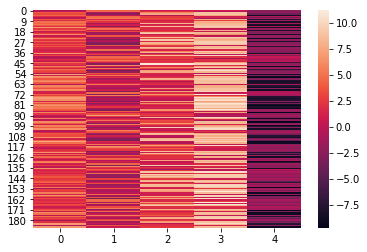

Distribution of pairwise distances


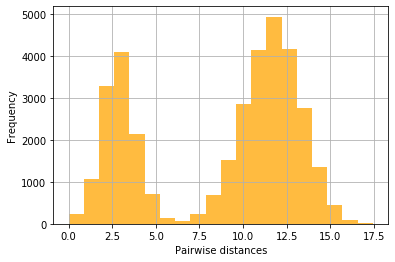

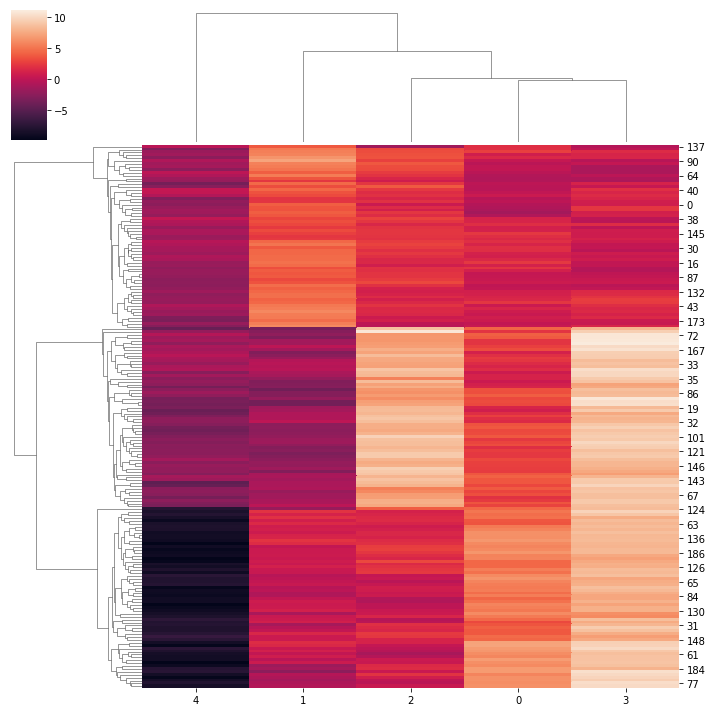

{2: 0.9295977678030928, 3: 0.9195065848610686, 4: 0.9127203300449308, 5: 0.9035714341349002, 6: 0.9025168595796991, 7: 0.8125056955957872, 8: 0.8100972141703798, 9: 0.8106838450794187}


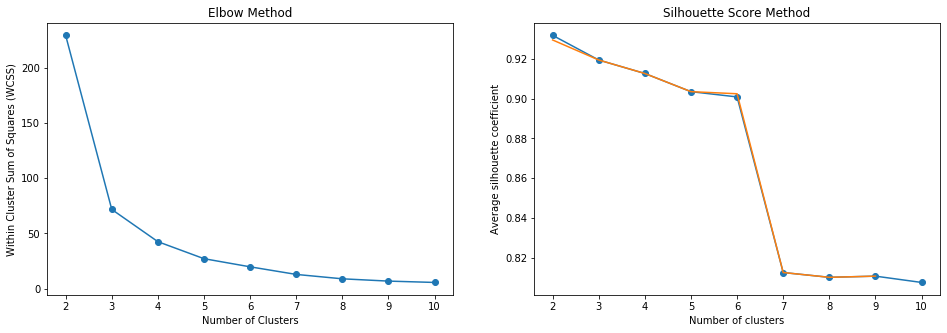

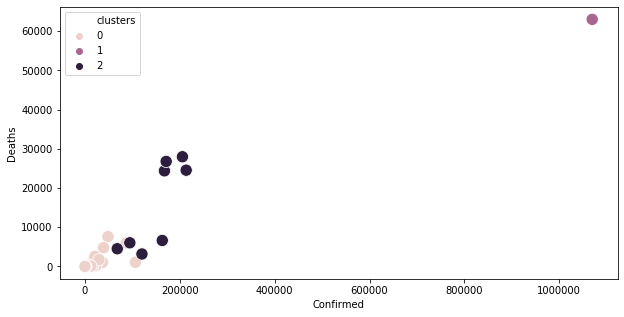

In [8]:
import seaborn as sns
from sklearn.datasets import make_blobs
from sklearn.metrics import pairwise_distances
X, y = make_blobs(n_samples = len(covid), centers = 3, n_features = 5, random_state=0, cluster_std = 1.0)

sns.heatmap(X)
plt.show()

D = pairwise_distances(X, metric='euclidean', n_jobs=-1)
print("Distribution of pairwise distances")

plt.hist(np.hstack(D), 20, facecolor='orange', alpha=0.75)
plt.xlabel('Pairwise distances')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

sns.clustermap(X)
plt.show()

########### 
covid.columns
X = covid[["Confirmed","Deaths","Recovered"]]
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,silhouette_samples

std = StandardScaler()
X = std.fit_transform(X)
wcss = []
sil = []
for i in range(2,11):
    clf = KMeans(n_clusters=i,init='k-means++',random_state=42)
    clf.fit(X)
    labels = clf.labels_
    centroids = clf.cluster_centers_
    sil.append(silhouette_score(X, labels, metric='euclidean'))
    wcss.append(clf.inertia_)
    
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,5))
x = np.arange(2,11)
ax1.plot(x, wcss, marker='o')
ax1.set_xlabel("Number of Clusters")
ax1.set_ylabel("Within Cluster Sum of Squares (WCSS)")
ax1.set_title("Elbow Method")
x=np.arange(2,11)
ax2.plot(x,sil,marker='o')
ax2.set_xlabel("Number of Clusters")
ax2.set_ylabel("Silhouette Score")
ax2.set_title("Silhouette Score Method")

def plot_silhouette_diagnostics(n_clusters):
    # Compute the silhouette scores 
    kmeans = KMeans(n_clusters=n_clusters).fit(X)
    lbls = kmeans.labels_
    values = silhouette_samples(X, lbls)
    
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i
        v = sorted(values[lbls == i])
        cluster_size = len(v)
        y_upper = y_lower + cluster_size

        # color mapping:
        c = plt.cm.Set1(color_scale[i])
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, v, facecolor=c, edgecolor=c, alpha=0.8)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * cluster_size, str(i))
        y_lower = y_upper + 1

    ax.set_xlabel("Silhouette coefficient")
    ax.set_ylabel("Cluster label")

    # Red dashed line shows an average silhouette score across all samples in all clusters
    score = silhouette_score(X, lbls, metric='l2')
    ax.axvline(x=score, color="red", linestyle="--")
    ax.set_yticks([])
    plt.show()


# Silhouette is used for assessing the performance of an unlabeled dataset
def calc_silhouette(dataset, n):
    """Runs Kmeans clustering and returns average silhouette coefficient"""    
    kmeans = KMeans(n_clusters=n).fit(dataset)
    score = silhouette_score(dataset, kmeans.labels_)
    return score

scores = {n: calc_silhouette(X, n) for n in range(2, 10)}
plt.plot(
    list(scores.keys()),
    list(scores.values())
)
print(scores)

plt.xlabel("Number of clusters")
plt.ylabel("Average silhouette coefficient")
plt.show()

#####################################    

clf_final = KMeans(n_clusters = 3, init='k-means++', random_state = 42)
clf_final.fit(X) 
covid["clusters"] = clf_final.predict(X)

pd.concat([covid[covid["clusters"]==1],covid[covid["clusters"]==2],covid[covid["clusters"]==3],covid[covid["clusters"]==0].all()])
### following the cluster description: cluster 0 is for nn affected, cluster 1 is for severely affected and cluster 2 worst affected
fig = plt.figure(figsize=(10,5))
sns.scatterplot(x=covid["Confirmed"],y=covid["Deaths"],hue=covid["clusters"], s = 150)


In [9]:
US = ts[ts['Country']=='US'].groupby('Date')['Confirmed','Deaths','Recovered'].sum().reset_index(False)
print(US.Confirmed.max())
Spain = ts[ts['Country']=='Spain'].groupby('Date')['Confirmed','Deaths','Recovered'].sum().reset_index(False)
print(Spain.Confirmed.max())
China = ts[ts['Country']=='China'].groupby('Date')['Confirmed','Deaths','Recovered'].sum().reset_index(False)
print(China.Confirmed.max())

1069424.0
213435.0
83956.0


#### Using KMeans we can see two clear clusters, but the silhouette method stresses how the US data is a clear outlier with five times more the number of cases with respect to countries like Spain or China. Therefore it could be interesting to focus the next steps to a model that could well fit only US data. Before deciding which model we can compare it is useful to have a look at how the curve for positive cases and deaths changed over time, even if the Covid-19 has only recently hit the US. 
### In the following dataset we see US data till mid March and it is clear how the curve for positive cases exponentially increases.

  Province/State Country/Region   Lat   Long  1/22/20  1/23/20  1/24/20  \
0            NaN       Thailand  15.0  101.0        2        3        5   

   1/25/20  1/26/20  1/27/20  ...  3/5/20  3/6/20  3/7/20  3/8/20  3/9/20  \
0        7        8        8  ...      47      48      50      50      50   

   3/10/20  3/11/20  3/12/20  3/13/20  3/14/20  
0       53       59       70       75       82  

[1 rows x 57 columns]


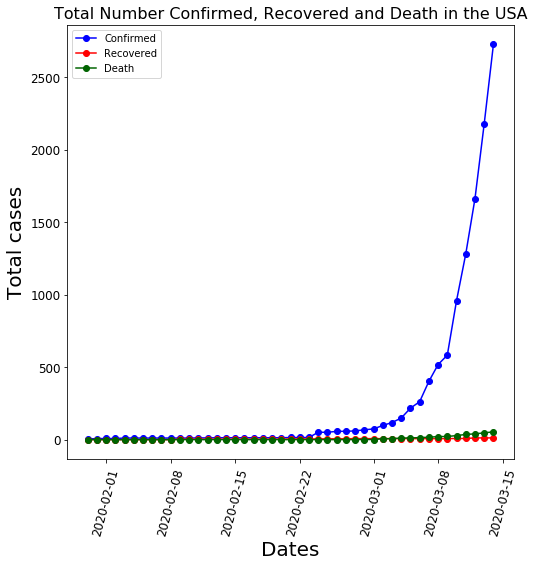

In [10]:
## Another files here____I am using a different visualization for the US data
df_confirmed = pd.read_csv("/Users/palmieril2/Downloads/time_series_covid_19_confirmed.csv")
df_deaths = pd.read_csv("/Users/palmieril2/Downloads/time_series_covid_19_deaths.csv")
df_recovered = pd.read_csv("/Users/palmieril2/Downloads/time_series_covid_19_recovered.csv")
print(df_confirmed.head(1))
dates = list(df_confirmed.columns[4:])
dates = list(pd.to_datetime(dates))
dates_US = dates[8:]
df1 = df_confirmed.groupby('Country/Region').sum().reset_index()
df2 = df_deaths.groupby('Country/Region').sum().reset_index()
df3 = df_recovered.groupby('Country/Region').sum().reset_index()
k = df1[df1['Country/Region']=='US'].loc[:,'1/30/20':]
CON = k.values.tolist()[0] 
k = df2[df2['Country/Region']=='US'].loc[:,'1/30/20':]
DEA = k.values.tolist()[0] 
k = df3[df3['Country/Region']=='US'].loc[:,'1/30/20':]
REC = k.values.tolist()[0] 
plt.figure(figsize= (8,8))
plt.xticks(rotation = 75,fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel("Dates",fontsize = 20)
plt.ylabel('Total cases',fontsize = 20)
plt.title("Total Number Confirmed, Recovered and Death in the USA" , fontsize = 16)

ax1 = plt.plot_date(y= CON,x= dates_US,label = 'Confirmed',linestyle ='-',color = 'blue')
ax2 = plt.plot_date(y= REC,x= dates_US,label = 'Recovered',linestyle ='-',color = 'red')
ax3 = plt.plot_date(y= DEA,x= dates_US,label = 'Death',linestyle ='-',color = 'darkgreen')
plt.legend();

          Date  Confirmed   Deaths  Recovered
99  2020-04-30  1069424.0  62996.0   153947.0


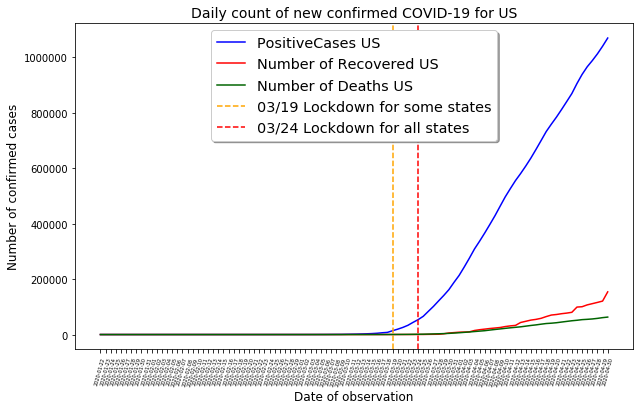

In [11]:
fig, ax =  plt.subplots(1,1, figsize=(10,6))
ts1 = ts[ts['Country']=='US'].groupby('Date')['Confirmed','Deaths','Recovered'].sum().reset_index(False)
ax.plot(ts1["Date"],ts1["Confirmed"], label = 'PositiveCases US', zorder = 1, color='blue')
ax.plot(ts1["Date"],ts1["Recovered"], label = 'Number of Recovered US', zorder = 2, color='red')
ax.plot(ts1["Date"],ts1["Deaths"], label = 'Number of Deaths US', zorder = 3, color = 'darkgreen')
ax.axvline(ts1[(ts1['Date']  == '2020-03-19')].index.tolist(), color="orange", linestyle="--", label = '03/19 Lockdown for some states')
ax.axvline(ts1[(ts1['Date']  == '2020-03-24')].index.tolist(), color="red", linestyle="--", label = '03/24 Lockdown for all states')
legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')
legend.get_frame().set_facecolor('white')
ax.set_title("Daily count of new confirmed COVID-19 for US", fontsize=14)
ax.set_xlabel("Date of observation", fontsize=12)

plt.xticks(rotation=75, fontsize=5)
ax.set_ylabel("Number of confirmed cases",fontsize=12)
print(ts1.tail(1))
plt.show()

### Here we have more recent data till the end of April and after less than a month (see previous plot) both curves for positive and deaths steadily increased with an expected exponential manner. Here below I highlighted in the Shaded area the period where the lockdown was set for the US. Two vertical lines mark a portion of the curve that cover the number of positive cases after 20 and 40 days from the beginning of the lockdown..

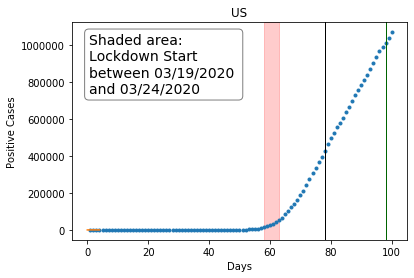

In [12]:
#### selecting the features and reordering data within the matrices I will use later on
train_n = ts
train_n['days'] = list(range(1,len(train_n)+1))
###retrieve confirmed, deaths and recoveries from main matrix ts
df_US = train_n[train_n['Country']=='US'].groupby('Date')['Confirmed','Deaths','Recovered'].sum()
df_US['days'] = list(range(1,len(df_US)+1))
df_US['rate'] = (df_US.Confirmed-df_US.Confirmed.shift(1))/df_US.Confirmed
df_US['increase'] = (df_US.Confirmed-df_US.Confirmed.shift(1))

fig, ax = plt.subplots(1,1)
ax.plot(df_US.days, df_US.Confirmed, '.')
ax.set_title("US")
ax.set_ylabel("Positive Cases")
ax.set_xlabel("Days")
ax.plot(range(5))
begin1 = train_n.loc[train_n['Date']== '2020-03-19', 'days']
begin2 = train_n.loc[train_n['Date']== '2020-03-24', 'days']
ax.axvspan(begin1.iloc[0],begin2.iloc[0], alpha=0.2, color='red')
textstr = 'Shaded area:\nLockdown Start\nbetween 03/19/2020 \nand 03/24/2020'
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
ax.axvline(x=begin1.iloc[0]+20,linewidth=1, color='black')
ax.axvline(x=begin1.iloc[0]+40,linewidth=1, color='darkgreen')
plt.show()

#### ...and here something a interesting is coming out. That portion of the curve does not really seem like an exponential growth, but more like a linear increment. We know from classic epidemiology (SIR model) that with a virus like the novel Covid-19 we would expect an exponential increment if no measurements are applied. As we can see in the plots below, it seems fairly easy to fit a linear regression over the data after the 03/24, when the lockdown was applied! I fit a linear regression on the data from 03/19 and from 03/24 the last day available in the dataset I chose. Therefore, it is important to underline how the lockdown is effective just after 5 days of its beginning, coverting an exponential to a linear fit!

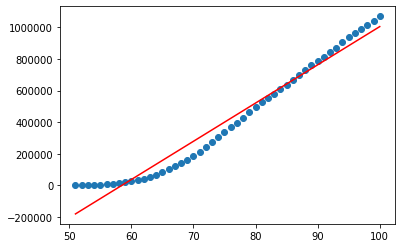

In [14]:
X = df_US['days'][50:].values.reshape(-1, 1)  
Y = df_US['Confirmed'][50:].values.reshape(-1, 1) 
from sklearn.linear_model import LinearRegression
linear_regressor = LinearRegression()  
linear_regressor.fit(X, Y)  
Y_pred = linear_regressor.predict(X) 
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()

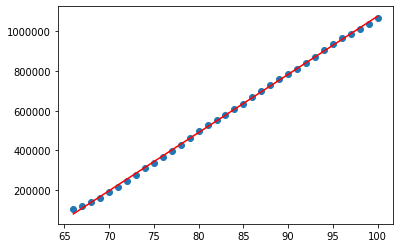

In [15]:
X = df_US['days'][65:].values.reshape(-1, 1)  
Y = df_US['Confirmed'][65:].values.reshape(-1, 1) 
linear_regressor = LinearRegression()  
linear_regressor.fit(X, Y)  
Y_pred = linear_regressor.predict(X) 
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()

#### In the plot above it is important to underline how the curve begins steeper after the lockdown. Is it possible for a linear regressor to fit well the data and possibly estimate the future number of cases? Additionally, if we consider 10 countries in the world with a high number of cases is there some similarities between the population size and the number of cases? 

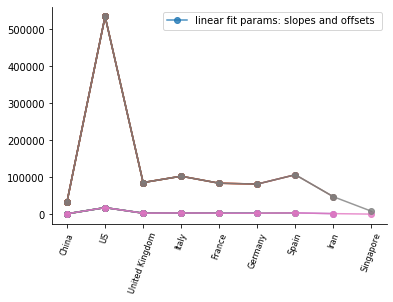

In [16]:
train = pd.DataFrame(ts.groupby(['Country'])['Date','Confirmed','Deaths','Recovered'].max().reset_index())
train['Date'] = pd.to_datetime(train['Date'])
train['Day'] = train['Date'].dt.day
selection = ['China','US','United Kingdom', 'Italy','France','Germany','Spain','Iran','Singapore']
populationsize = [1439323776, 327200000, 678890000, 60360000, 66990000, 83020000, 46940000, 81800000, 5639000]

def Get(mask, dataframe, selection, xm, ym, zm, pop):
    m1 = dataframe[selection] == mask
    x = dataframe[m1][xm]
    y = dataframe[m1][ym]
    p = np.polyfit(x, y, 1)
    cases = dataframe[m1][ym]
    cpm = cases.max() * 10 **6 /pop
    cfr = dataframe[m1][zm].sum()/dataframe[m1][ym].sum()                
    return p, cpm, cfr 

pp = []
cpm = []
cfr = []
fig, axs = plt.subplots(1,1)
ind = np.arange(len(selection))
for i in selection:
        p, cases, cf = Get(i, train, 'Country', 'Day', 'Confirmed','Deaths', populationsize)
        pp.append(p)
        axs.plot(pp, marker='o', alpha=0.8)
        axs.spines['top'].set_visible(False); 
        axs.spines['right'].set_visible(False);
        axs.spines['bottom'].set_visible(True); 
        axs.spines['left'].set_visible(True);
        axs.label_outer(); plt.legend(["linear fit params: slopes and offsets "])
        plt.xticks(ind, selection, fontsize=8, rotation=70)
        cpm.append(cases)
        cfr.append(cf)

[0.06622827618600281, 0.05890647675758165, 0.15632426877193392, 0.13611696509833887, 0.1454371886280242, 0.040629658485114316, 0.11499051233396584, 0.06369399830938292, 0.0009277011565341084]


Text(0.5, 1.0, 'Case Fatality rates')

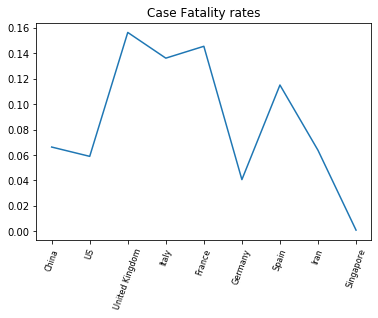

In [17]:
print(cfr)
plt.plot(cfr)
plt.xticks(ind, selection, fontsize=8, rotation=70)
plt.title("Case Fatality rates")

#### Plotting the slopes of a linear fit for the most 10 affected countries in the world possibly underlines how the US is at the moment the country with the highest number of active cases, but if we take a look at the mortality rates for the 10 countries I chose as example we can definitely agree that the Case Fatality Rate is not the highest given the large population of a country such as the US. We also need to consider that the Covid-19 seems to have reached the US later with respect to the countries in the example above, so it could also means that it's only a matter of time and that rate may increase. How well could be able to estimate future predictions? Which ML tool is the most useful here? 

#### Since there is no direct correlation with the population density and the number of positive cases or Fatality rate, and given the effectiveness of the lockdown on the curves we have seen previously, it would be definitely interesting to understand what kind of model we could use to predict future cases.
### **US case:** *Could we predict, given the actual number of positive cases, the future number of deaths and recoveries?*
#### To answer these questions I am going to try a few ML algoriths. The problem I am adressing here is that I am looking for a regressor, so I would like to train the data and make future predictions. I am using the most recent updated dataset available and sklearn package (LinearRegressor, SVRegressor, RandomForestRegressor..). I will try to fit a linear regression and a ridge regression to predict future positive cases. I am going to show model comparisions for both deaths and recoveries and concludes with a sigmoid model. 
#### *I would like to point out that there is a chance of overfitting in the data I used and as many others pointed out on the internet the novelty of this virus makes it difficult to have a very big dataset. I clarify that I am showing the following analysis after have tried to change parameters such as n_estimators or sample_leaf within the sklearn algorithms. I conclude that the score I calculated are the best choices this question here, however additional analysis would be required to optimize the hyperparameters for the fits used. At the end of each plot I printed score values or error values for the fit used as accuracy estimate.* 
#### Future directions: I do not exclude the use of Keras or RNN for this specific question, however my experience in reading this data tells me that a different growth models applied on a sigmoid fit or the use of better parameters on the present sigmoid fit may work well in fitting the future cases for the Covid-19.

In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
####################################################################
#### Predicting Deaths
####################################################################
x_deaths = df_US[['Confirmed','Recovered']]
y_deaths = df_US[['Deaths']]

xtrain_d, xtest_d, ytrain_d, ytest_d = train_test_split(x_deaths, y_deaths, test_size = 0.2, random_state = 42)
rf = RandomForestRegressor(n_estimators = 150, n_jobs = -1, min_samples_leaf = 3, random_state = 42)
rf.fit(xtrain_d,ytrain_d)
rf.score(xtest_d,ytest_d)
rf.feature_importances_
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, accuracy_score, plot_confusion_matrix
Y_pred_d = rf.predict(xtest_d)
#mse
msed = np.sqrt(mean_squared_error(ytest_d,Y_pred_d))
print(msed)
#print(mean_squared_error(ytest_d,np.round(Y_pred_d)))
#print(classification_report(ytest_d, np.round(Y_pred_d)))
########################################################################
#### Predicting Recovered
########################################################################\
x_recov = df_US[['Confirmed','Deaths']]
y_recov = df_US[['Recovered']]
xtrain_r, xtest_r, ytrain_r, ytest_r = train_test_split(x_recov, y_recov, test_size = 0.2, random_state = 42)
rf = RandomForestRegressor(n_estimators = 150, n_jobs = -1, min_samples_leaf = 3, random_state = 42)
rf.fit(xtrain_r,ytrain_r)
rf.score(xtest_r,ytest_r)
#### Predicting 
rf.feature_importances_
Y_pred_r = rf.predict(xtest_r)
mser = np.sqrt(mean_squared_error(ytest_r,Y_pred_r))
print(mser)
#print(mean_squared_error(ytest_r,np.round(Y_pred_r)))
#print(classification_report(ytest_r, np.round(Y_pred_r)))

1174.6349939651816
2504.333697290337


In [19]:
from sklearn.model_selection import StratifiedKFold, ShuffleSplit, learning_curve, cross_val_score, KFold, GridSearchCV,train_test_split
from sklearn.ensemble import RandomForestClassifier
def plot_learning_curve_complete(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):

    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt
#############################
    ### plotting fcn
def plot_learning_curve(estimator, title, label1, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.3, 1.0, 10)):
    #plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring="neg_mean_squared_error")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label=label1)

    plt.legend(loc="best")
    return plt

#### **CASE 1: Regressor for Deaths**

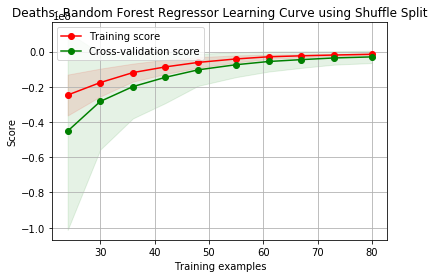

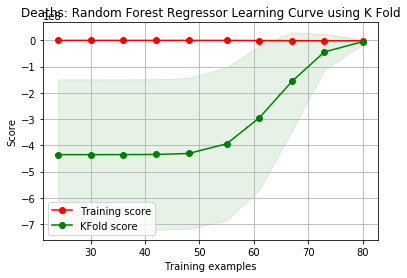

In [20]:
f = RandomForestRegressor()
ss = ShuffleSplit(n_splits=100, test_size=0.2, random_state=10)
s1 = cross_val_score(rf, x_deaths, y_deaths, cv=ss)
title = "Deaths: Random Forest Regressor Learning Curve using Shuffle Split"
label = "Cross-validation score"

plot_learning_curve(rf, title, label, x_deaths, y_deaths, cv=ss, n_jobs=4)
plt.show()
kfld  = KFold(n_splits=5, shuffle=True, random_state=10)
title = "Deaths: Random Forest Regressor Learning Curve using K Fold"
label = "KFold score"
plot_learning_curve(rf, title, label, x_deaths, y_deaths, cv=kfld, n_jobs=4)
plt.show()
s2 = cross_val_score(rf,x_deaths, y_deaths, cv=kfld)


In [21]:
### residuals:
print(s1.mean()) 
print(s2.mean()) 

0.9904840664950219
0.989544984649207


#### **Case 2: Regresson for Recoveries**

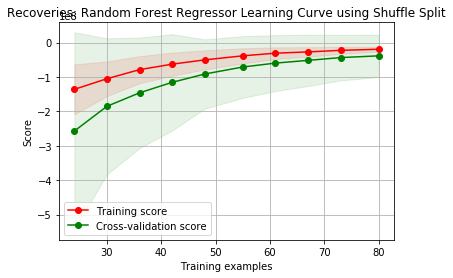

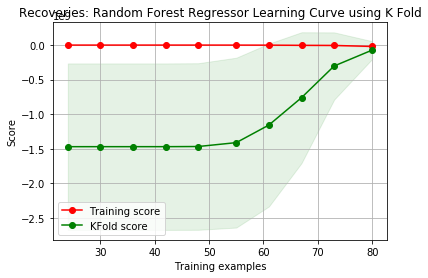

In [22]:
f = RandomForestRegressor()
ss = ShuffleSplit(n_splits=100, test_size=0.2, random_state=10)
s1 = cross_val_score(rf, x_recov, y_recov, cv=ss)
title = "Recoveries: Random Forest Regressor Learning Curve using Shuffle Split"
label = "Cross-validation score"

plot_learning_curve(rf, title, label, x_recov, y_recov, cv=ss, n_jobs=4)
plt.show()

kfld  = KFold(n_splits=5, shuffle=True, random_state=10)
title = "Recoveries: Random Forest Regressor Learning Curve using K Fold"
label = "KFold score"
plot_learning_curve(rf, title, label, x_recov, y_recov, cv=kfld, n_jobs=4)
plt.show()
s2 = cross_val_score(rf, x_recov, y_recov, cv=kfld)


In [23]:
#residuals:
print(s1.mean()) 
print(s2.mean()) 

0.9742865668777329
0.9646162481134629


In [ ]:
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, BayesianRidge, Lasso, Ridge
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error

fig, axs = plt.subplots(2, 2, figsize=(10, 15))
cv_iterator = KFold(n_splits =5, shuffle = True, random_state=10)
model = LinearRegression()
title = "Deaths: Learning Curve LinReg"
label = "KFold score"
plt.subplot(221)
# plt.subplots_adjust(wspace=0.3, hspace=0.3); 
plot_learning_curve(model, title, label, x_deaths, y_deaths, cv=cv_iterator, n_jobs=4)
plt.tight_layout()
#plt.show()

title = "Recoveries: Learning Curve LinReg"
label = "KFold score"
plt.subplot(222)
plot_learning_curve(model, title, label,  x_recov, y_recov, cv=cv_iterator, n_jobs=4)
plt.tight_layout()
#plt.show()

model = RandomForestRegressor()
title = "Deaths: Learning Curve RndForestR"
label = "KFold score"
plt.subplot(223)
# plt.subplots_adjust(wspace=0.3, hspace=0.3); 
plot_learning_curve(model, title, label, x_deaths, y_deaths, cv=cv_iterator, n_jobs=4)
plt.tight_layout()
#plt.show()

title = "Recoveries: Learning Curve RndForestR"
label = "KFold score"
plt.subplot(224)
plot_learning_curve(model, title, label, x_recov, y_recov, cv=cv_iterator, n_jobs=4)
plt.tight_layout()
plt.show()

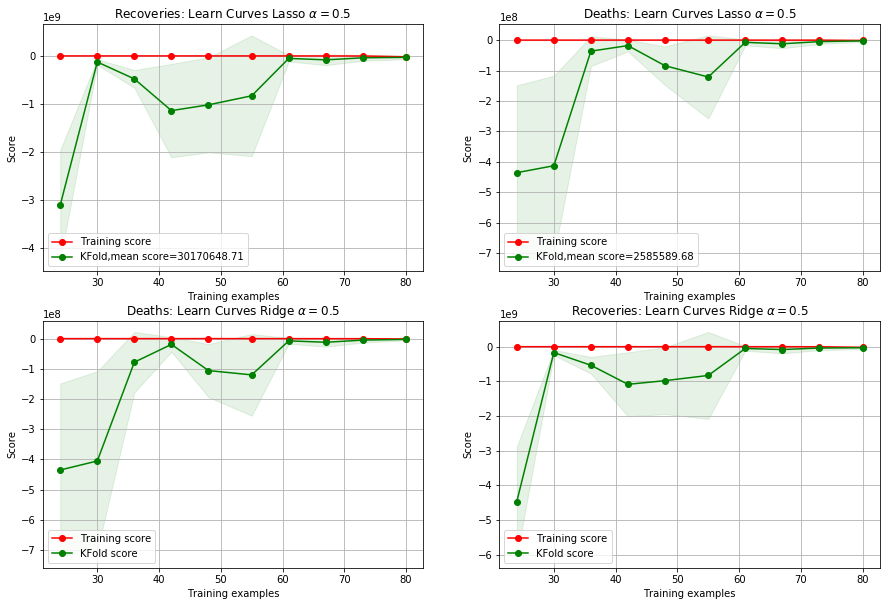

In [20]:
fig = plt.subplots(2, 2, figsize=(15,10))
title = r"Recoveries: Learn Curves Lasso $\alpha=0.5$"
cv_iterator = KFold(n_splits=5, shuffle=True, random_state=10)
llr = Lasso(alpha=0.5)
llr.fit(x_recov,y_recov)
preds = llr.predict(x_recov)
cross_val_score(llr, x_recov, y_recov, cv=5, scoring="neg_mean_squared_error")
meanlassorec = np.mean(-cross_val_score(llr,  x_recov, y_recov, cv=cv_iterator, scoring="neg_mean_squared_error"))
abs(meanlassorec)
label = "KFold,mean score=%.2f" % (meanlassorec)
plt.subplot(221)
plot_learning_curve(llr, title, label, x_recov, y_recov, cv=cv_iterator, n_jobs=4)
#plt.show()

title = r"Deaths: Learn Curves Lasso $\alpha=0.5$"
llr.fit(x_deaths,y_deaths)
preds = llr.predict(x_deaths)
cross_val_score(llr, x_deaths, y_deaths, cv=5, scoring="neg_mean_squared_error")
meanlassodet = np.mean(-cross_val_score(llr,  x_deaths, y_deaths, cv=cv_iterator, scoring="neg_mean_squared_error"))
abs(meanlassodet)
label = "KFold,mean score=%.2f" % (meanlassodet)

plt.subplot(222)
plot_learning_curve(llr, title, label, x_deaths, y_deaths, cv=cv_iterator, n_jobs=4)
#plt.show()

title = r"Deaths: Learn Curves Ridge $\alpha=0.5$"
label = "KFold score"
cv_iterator = KFold(n_splits=5, shuffle=True, random_state=10)
llr = Ridge(alpha=0.5)
plt.subplot(223)
plot_learning_curve(llr, title, label, x_deaths, y_deaths, cv=cv_iterator, n_jobs=4)
#plt.show()

title = r"Recoveries: Learn Curves Ridge $\alpha=0.5$"
label = "KFold score"
plt.subplot(224)
plot_learning_curve(llr, title, label,  x_recov, y_recov, cv=cv_iterator, n_jobs=4)
plt.show()

#### Logistic Regression additional

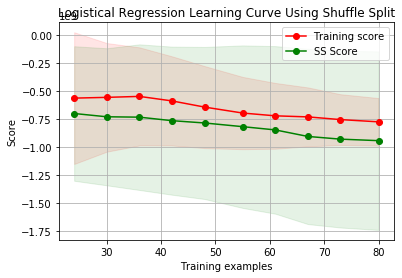

0.0


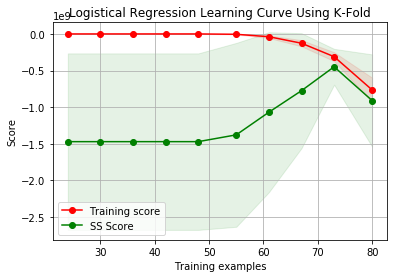

In [21]:
### Logistical Regression Learning Curve  
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(solver='lbfgs', max_iter=1000)
####recoveries
ss = ShuffleSplit(n_splits=100, test_size=0.2, random_state=10)
title = "Logistical Regression Learning Curve Using Shuffle Split"
label = "SS Score"
plot_learning_curve(logreg, title, label, x_recov, y_recov, cv=ss, n_jobs=4)
plt.show()
cv_iterator = KFold(n_splits =5, shuffle = True, random_state=10)
title = "Logistical Regression Learning Curve Using K-Fold"
plot_learning_curve(logreg, title, label, x_recov, y_recov, cv=cv_iterator, n_jobs=4)
s = cross_val_score(logreg, x_recov, y_recov, cv=cv_iterator)
print(s.mean())
plt.show()


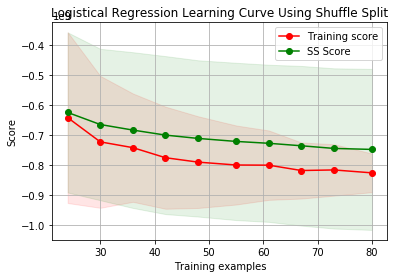

0.0


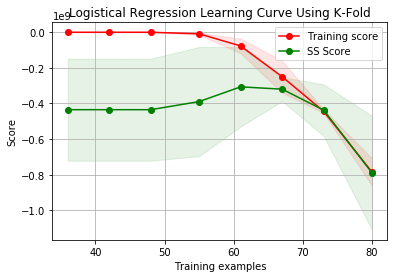

In [22]:
####deaths
ss = ShuffleSplit(n_splits=100, test_size=0.2, random_state=10)
title = "Logistical Regression Learning Curve Using Shuffle Split"
label = "SS Score"
plot_learning_curve(logreg, title, label, x_deaths, y_deaths, cv=ss, n_jobs=4)
plt.show()
cv_iterator = KFold(n_splits =5, shuffle = True, random_state=10)
title = "Logistical Regression Learning Curve Using K-Fold"
plot_learning_curve(logreg, title, label, x_deaths, y_deaths, cv=cv_iterator, n_jobs=4)
s = cross_val_score(logreg, x_recov, y_recov, cv=cv_iterator)
print(s.mean())
plt.show()

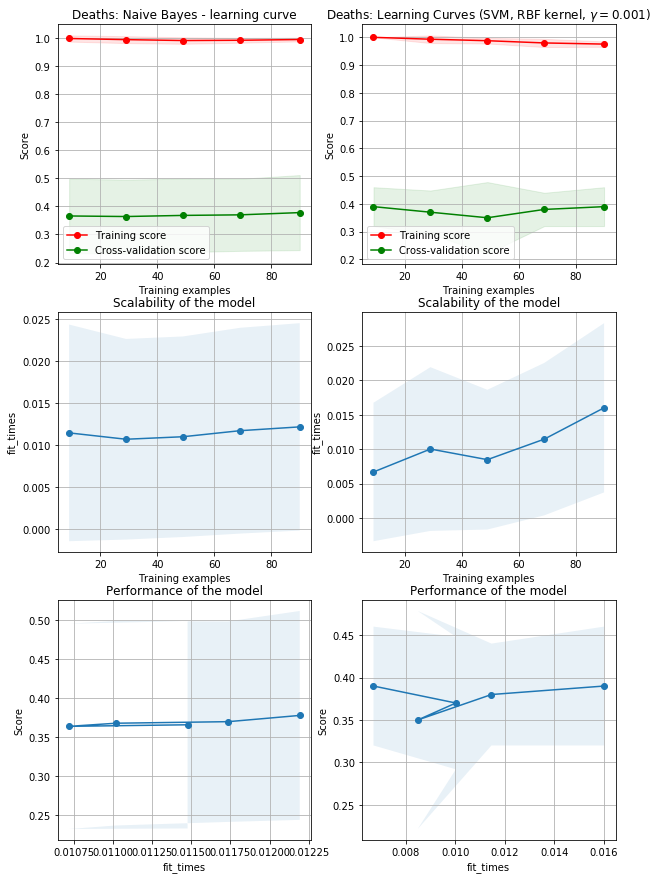

In [23]:
fig, axes = plt.subplots(3, 2, figsize=(10, 15))
title = 'Deaths: Naive Bayes - learning curve'
cvnb = ShuffleSplit(n_splits=100, test_size=0.1, random_state=10)
from sklearn.naive_bayes import GaussianNB
NB = GaussianNB()
plot_learning_curve_complete(NB, title, x_deaths, y_deaths, axes=axes[:, 0], ylim=None,
                    cv=cvnb, n_jobs=4)
# For SVC: lower number of CV iterations used given it's quite expensive
title = r"Deaths: Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
cvsv = ShuffleSplit(n_splits=10, test_size=0.1, random_state=10)
from sklearn.svm import SVC
sv = SVC(gamma=0.001)
plot_learning_curve_complete(sv, title, x_deaths, y_deaths, axes=axes[:, 1], ylim=None,
                    cv=cvsv, n_jobs=4)
plt.show()

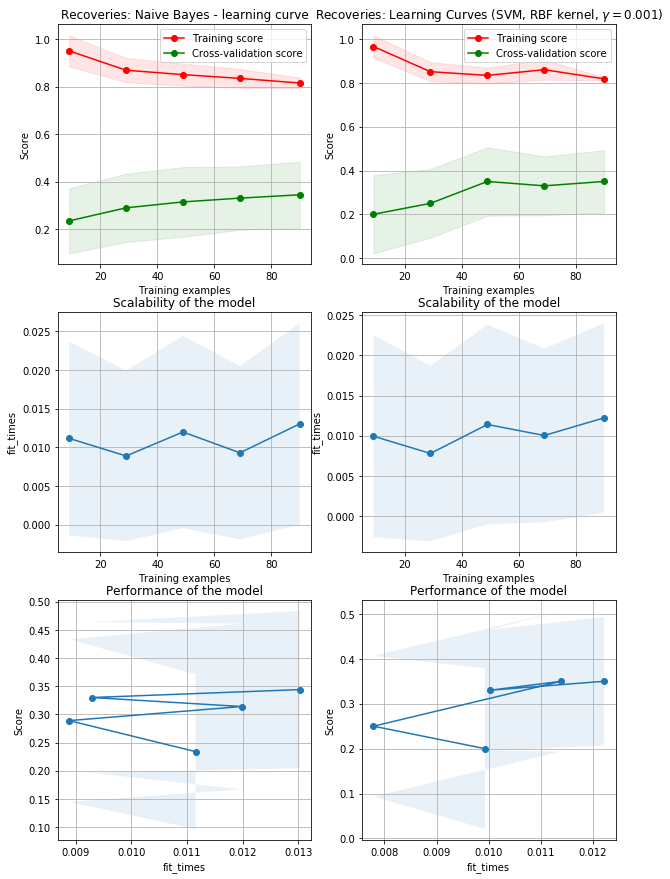

In [24]:
fig, axes = plt.subplots(3, 2, figsize=(10, 15))
title = 'Recoveries: Naive Bayes - learning curve'
cvnb = ShuffleSplit(n_splits=100, test_size=0.1, random_state=10)
from sklearn.naive_bayes import GaussianNB
NB = GaussianNB()
plot_learning_curve_complete(NB, title, x_recov, y_recov, axes=axes[:, 0], ylim=None,
                    cv=cvnb, n_jobs=4)
# For SVC: lower number of CV iterations used given it's quite expensive
title = r"Recoveries: Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
cvsv = ShuffleSplit(n_splits=10, test_size=0.1, random_state=10)
from sklearn.svm import SVC
sv = SVC(gamma=0.001)
plot_learning_curve_complete(sv, title, x_recov, y_recov, axes=axes[:, 1], ylim=None,
                    cv=cvsv, n_jobs=4)
plt.show()

In [122]:
from scipy.optimize import curve_fit
df_US['Active'] = df_US['Confirmed']-df_US['Deaths']-df_US['Recovered']
df_US = df_US[df_US.Active>=50]

def sigmoid(x,c,a,b):
     y = c*1 / (1 + np.exp(-a*(x-b)))
     return y

days = np.array(list(df_US.days)[::2])
active_cases = np.array(list(df_US.Active)[::2])

##from Google I get the population of the US
population = 327.2*10**9
params, cova = curve_fit(sigmoid, days, active_cases, method='dogbox',bounds=([0.,0., 0.],[population,5, 100.]))
est_a = params[0]
est_b = params[1]
est_c = params[2]

day_inthe_future = 100
x = np.linspace(days[0]-20, days[-1]+ day_inthe_future, 50)
y = sigmoid(x,est_a,est_b,est_c)

print(params)

[3.72387176e+05 1.14521374e-01 5.36580263e+01]


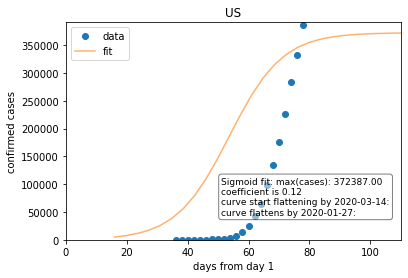

model fitted max Active cases at: 372387
model sigmoidal coefficient is: 0.115
model curve stop steepening, start flattening after day: 53
model curve flattens after day: 106


In [123]:
plt.plot(days, active_cases, 'o', label='data')
plt.plot(x,y, label='fit',alpha = 0.6)
plt.ylim(0, est_a * 1.05)
plt.xlim(0, est_c * 2.05)
plt.legend(loc='best')
plt.xlabel('days from day 1')
plt.ylabel('confirmed cases')
plt.title('US')

start = train_n.loc[train_n['days']== int(est_c), 'Date'].values[0]
end = train_n.loc[train_n['days']== int(est_c) * 2, 'Date'].values[0]

textstr = '\n'.join((
    r'Sigmoid fit: max(cases): %.2f' %(int(est_a),),
    r'coefficient is %.2f' %(round(est_b,3),),
    r'curve start flattening by %s:' %(int(est_c),),
    r'curve flattens by %s:' %(int(est_c)*2,)))
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
plt.text(0.5, 0.3, textstr, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=props)
plt.show()


print('model fitted max Active cases at:',int(est_a))
print('model sigmoidal coefficient is:',round(est_b,3))
print('model curve stop steepening, start flattening after day:',int(est_c))
print('model curve flattens after day:',int(est_c)*2)

In [118]:
def guess_plateau(x, y): ##optimization for sigmoid function finding a plateu point
    if len(x) != len(y):
        return 0

    diffs = []
    indexes = range(len(y))

    for i in indexes:
        if i + 1 not in indexes:
            continue
        diffs.append(y[i + 1] - y[i])
    diffs = np.array(diffs)

    ymax = y[-1]
    for i in indexes:
        if y[i] > (ymax - diffs.std()) and y[i] < (ymax + diffs.std()):
            ymax = y[i]
            break

    return ymax
def guess_lag(x, y):###lag point estimate for sigmoid
    if len(x) != len(y):
        return 0

    diffs = []
    indexes = range(len(x))

    for i in indexes:
        if i + 1 not in indexes:
            continue
        diffs.append(y[i + 1] - y[i])
    diffs = np.array(diffs)

    flex = x[-1]
    for i in indexes:
        if i + 1 not in indexes:
            continue
        if (y[i + 1] - y[i]) > (diffs.mean() + (diffs.std())):
            flex = x[i]
            break

    return flex

838291.0
70


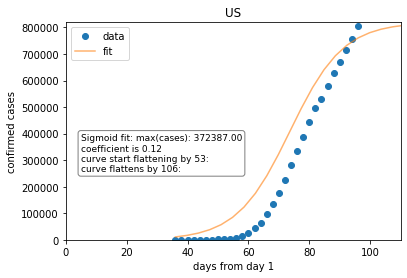

In [135]:
ymax = guess_plateau(days, active_cases)
print(ymax)
flex_point = guess_lag(days, active_cases)
print(flex_point)
best_param_day = flex_point - 50
best_scaling = 2.2
plt.plot(days, active_cases, 'o', label='data')
plt.plot(x + best_param_day,y * best_scaling, label='fit',alpha = 0.6)
plt.ylim(0, est_a * 2.2)
plt.xlim(0, est_c * 2.05)
plt.legend(loc='best')
plt.xlabel('days from day 1')
plt.ylabel('confirmed cases')
plt.title('US')
textstr = '\n'.join((
    r'Sigmoid fit: max(cases): %.2f' %(int(est_a),),
    r'coefficient is %.2f' %(round(est_b,3),),
    r'curve start flattening by %s:' %(int(est_c),),
    r'curve flattens by %s:' %(int(est_c)*2,)))
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
plt.text(0.08, 0.5, textstr, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=props)
plt.show()

In [162]:
train = pd.DataFrame(ts.groupby(['Country'])['Date','Confirmed','Deaths','Recovered'].max().reset_index())
train['Date'] = pd.to_datetime(train['Date'])
train['Day'] = train['Date'].dt.day
selection = ['China','US','United Kingdom', 'Italy','France','Germany','Spain','Iran','Singapore']
populationsize = [1439323776, 327200000, 678890000, 60360000, 66990000, 83020000, 46940000, 81800000, 5639000]

def Get(mask, dataframe, selection, xm, ym, zm):
    m1 = dataframe[selection] == mask
    x = dataframe[m1][xm]
    y = dataframe[m1][ym]
    z = dataframe[m1][zm]
    return x,y,z

x,y,z = Get('US', train, 'Country', 'Recovered', 'Confirmed','Deaths')
print(x)
print(y)
print(z)


173    153947.0
Name: Recovered, dtype: float64
173    1069424.0
Name: Confirmed, dtype: float64
173    62996.0
Name: Deaths, dtype: float64


array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan',
       'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'Brunei', 'Bulgaria', 'Burkina Faso', 'Burma', 'Burundi',
       'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Comoros', 'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Denmark',
       'Diamond Princess', 'Djibouti', 'Dominica', 'Dominican Republic',
       'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea',
       'Estonia', 'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France',
       'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece',
       'Grenada', 'Guatemala', 'Guin

In [168]:
##### future Estimates for world
df_confirmed = pd.read_csv("/Users/palmieril2/Downloads/time_series_covid_19_confirmed.csv")
df_deaths = pd.read_csv("/Users/palmieril2/Downloads/time_series_covid_19_deaths.csv")
df_recovered = pd.read_csv("/Users/palmieril2/Downloads/time_series_covid_19_recovered.csv")
import datetime as dt

###extraction
columns = df_confirmed.keys()
confirmed = df_confirmed.loc[:, columns[4]:columns[-1]]
deaths = df_deaths.loc[:, columns[4]:columns[-1]]
recovered = df_recovered.loc[:, columns[4]:columns[-1]]
########################################################
#### preparing mats for future predictions
dates = confirmed.keys()
all_cases = []
total_deaths = [] 
mortality_rate = []
total_recovered = [] 

In [171]:
## generate space of days knowing 30 days have passed since the beginning
for i in dates:
    confirmed_sum = confirmed[i].sum()
    death_sum = deaths[i].sum()
    recovered_sum = recovered[i].sum()
    all_cases.append(confirmed_sum)
    total_deaths.append(death_sum)
    mortality_rate.append(death_sum/confirmed_sum)
    total_recovered.append(recovered_sum)
 
days_in_future = 15
future_forcast = np.array([i for i in range(len(dates)+days_in_future)]).reshape(-1, 1)
adjusted_dates = future_forcast[:-15]

start = '1/22/2020'
start_date = dt.datetime.strptime(start, '%m/%d/%Y')
future_forcast_dates = []
day_since_first = np.array([i for i in range(len(dates))]).reshape(-1,1)

for i in range(len(future_forcast)):
    future_forcast_dates.append((start_date + dt.timedelta(days=i)).strftime('%m/%d/%Y'))

X_train_confirmed, X_test_confirmed, y_train_confirmed, y_test_confirmed = train_test_split(day_since_first, all_cases, test_size=0.15, shuffle=False) 

In [172]:
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression, BayesianRidge
linear_model = LinearRegression(normalize=True, fit_intercept=True)
linear_model.fit(X_train_confirmed, y_train_confirmed)
test_linear_pred = linear_model.predict(X_test_confirmed)
linear_pred = linear_model.predict(future_forcast)
print('MAE:', mean_absolute_error(test_linear_pred, y_test_confirmed))
print('MSE:',mean_squared_error(test_linear_pred, y_test_confirmed))
print(linear_model.coef_)
print(linear_model.intercept_)

MAE: 8753.452020202018
MSE: 169179593.56311837
[2554.46969697]
-5605.111111111139


In [173]:
linear_model.score(X_train_confirmed, y_train_confirmed)

0.9644899387649014

In [176]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error


bayesian_grid = {'tol': [1e-4, 1e-3, 1e-2], 'alpha_1': [1e-7, 1e-6, 1e-5, 1e-4],
                 'alpha_2' : [1e-7, 1e-6, 1e-5, 1e-4], 'lambda_1':  [1e-7, 1e-6, 1e-5, 1e-4],
                 'lambda_2' : [1e-7, 1e-6, 1e-5, 1e-4]}

bayesian = BayesianRidge()
bayesian_search = RandomizedSearchCV(bayesian, bayesian_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=40, verbose=1)
bayesian_search.fit(X_train_confirmed, y_train_confirmed)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.2s finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=BayesianRidge(alpha_1=1e-06, alpha_2=1e-06,
                                           alpha_init=None, compute_score=False,
                                           copy_X=True, fit_intercept=True,
                                           lambda_1=1e-06, lambda_2=1e-06,
                                           lambda_init=None, n_iter=300,
                                           normalize=False, tol=0.001,
                                           verbose=False),
                   iid='deprecated', n_iter=40, n_jobs=-1,
                   param_distributions={'alpha_1': [1e-07, 1e-06, 1e-05,
                                                    0.0001],
                                        'alpha_2': [1e-07, 1e-06, 1e-05,
                                                    0.0001],
                                        'lambda_1': [1e-07, 1e-06, 1e-05,
                                                 

In [177]:
bayesian_search.fit(X_train_confirmed, y_train_confirmed)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.2s finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=BayesianRidge(alpha_1=1e-06, alpha_2=1e-06,
                                           alpha_init=None, compute_score=False,
                                           copy_X=True, fit_intercept=True,
                                           lambda_1=1e-06, lambda_2=1e-06,
                                           lambda_init=None, n_iter=300,
                                           normalize=False, tol=0.001,
                                           verbose=False),
                   iid='deprecated', n_iter=40, n_jobs=-1,
                   param_distributions={'alpha_1': [1e-07, 1e-06, 1e-05,
                                                    0.0001],
                                        'alpha_2': [1e-07, 1e-06, 1e-05,
                                                    0.0001],
                                        'lambda_1': [1e-07, 1e-06, 1e-05,
                                                 

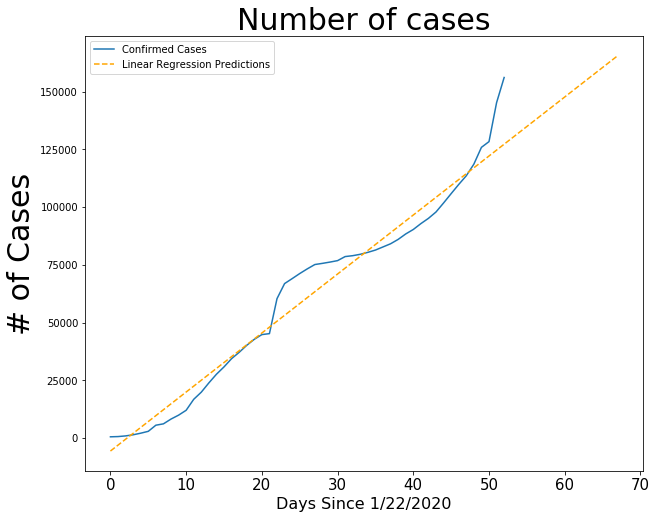

In [178]:
plt.figure(figsize=(10,8))
plt.plot(adjusted_dates, all_cases)
plt.plot(future_forcast, linear_pred, linestyle='dashed', color='blue')
plt.title('Number of cases', size=30)
plt.xlabel('Days Since 1/22/2020', size=16)
plt.ylabel('# of Cases', size=30)
plt.legend(['Confirmed Cases', 'Linear Regression Predictions'])
plt.xticks(size=15)
plt.show()

In [179]:
print('Linear regression future predictions:')
print(linear_pred[-15:])

Linear regression future predictions:
[129781.78282828 132336.25252525 134890.72222222 137445.19191919
 139999.66161616 142554.13131313 145108.6010101  147663.07070707
 150217.54040404 152772.01010101 155326.47979798 157880.94949495
 160435.41919192 162989.88888889 165544.35858586]


In [200]:
from sklearn.linear_model import Ridge
from bayes_opt import BayesianOptimization
   
def target(**params):
    fit_intercept = int(params['fit_intercept'])
    fit_intercept_dict = {0:False, 1:True}

    model = Ridge(alpha = params['alpha'],
                    fit_intercept = fit_intercept_dict[fit_intercept],
                    copy_X = True)
    
    scores = cross_val_score(model, X_train_confirmed, y_train_confirmed, cv=3)
    return scores.mean()
    
params = {'alpha':(1, 4),
          'fit_intercept':(0,1.99)}

bo = BayesianOptimization(target, params, random_state=seed)
bo.maximize(init_points=5, n_iter=10, acq='ucb', kappa=2

|   iter    |  target   |   alpha   | fit_in... |
-------------------------------------------------
|  1        | -1.486    |  2.549    |  1.136    |
|  2        |  0.3561   |  1.085    |  0.3413   |
|  3        | -1.484    |  3.056    |  1.659    |
|  4        | -1.488    |  1.921    |  1.778    |
|  5        |  0.3575   |  3.165    |  0.378    |
|  6        |  0.3579   |  3.767    |  0.0      |
|  7        |  0.3568   |  2.134    |  0.0      |
|  8        |  0.3574   |  2.978    |  0.0      |
|  9        |  0.3581   |  4.0      |  0.7783   |
|  10       |  0.3561   |  1.0      |  0.0      |
|  11       |  0.3564   |  1.538    |  0.01542  |
|  12       | -1.491    |  1.0      |  1.188    |
|  13       | -1.481    |  4.0      |  1.99     |
|  14       |  0.3581   |  4.0      |  0.3597   |
|  15       |  0.3578   |  3.61     |  0.4607   |


In [210]:
bo.res
bo.max
print(bo.max)
### Reading this info would give me the right info to change the boundaries for the model

{'target': 0.3581016605787499, 'params': {'alpha': 4.0, 'fit_intercept': 0.7783322501720423}}


In [204]:
### for this I can set manually the value of apha instead of rerunning the bayesian optimizer
model = Ridge(alpha = 4, fit_intercept = True, copy_X = True)

In [211]:
model.fit(X_train_confirmed, y_train_confirmed)
predFinal = model.predict(X_test_confirmed)
model.score(X_train_confirmed, y_train_confirmed)

0.964489721990862

### With a pretty good accuracy I can say that this latest version of bayesian Ridge can predict the number of positive case given the data available so far